In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Constants

num_inputs = 2
num_neurons = 3

In [3]:
# Placeholders

x0 = tf.placeholder(tf.float32, shape=[None, num_inputs])
x1 = tf.placeholder(tf.float32, shape=[None, num_inputs])

In [4]:
# Variables

Wx = tf.Variable(tf.random_normal([num_inputs, num_neurons]))
Wy = tf.Variable(tf.random_normal([num_neurons, num_neurons]))

b = tf.Variable(tf.zeros([1, num_neurons]))

In [5]:
# Graph

In [6]:
y0 = tf.tanh(tf.matmul(x0, Wx) + b)

In [7]:
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx) + b)

In [8]:
init = tf.global_variables_initializer()

In [9]:
# Create data

In [10]:
# Timestamp 0
x0_batch = np.array([
    [0, 1], [2, 3], [4, 5]
])

# Timestamp 1
x1_batch = np.array([
    [100, 101], [102, 103], [104, 105]
])

In [11]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run(
        [y0, y1],
        feed_dict={x0: x0_batch, x1: x1_batch}
    )

    print(y0_output_vals)
    print(y1_output_vals)

[[-0.95716614 -0.9021078   0.7236241 ]
 [-0.5448793  -0.9982063   0.99714273]
 [ 0.5972258  -0.9999687   0.99997467]]
[[ 1. -1.  1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]]


## RNN for real

In [12]:
class TimeSeriesData:
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)

    def ret_true(self, x_series):
        return np.sin(x_series)

    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # create batch time series on the x axis
        batch_ts = ts_start + np.arange(0, steps + 1) * self.resolution
        
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)

        # formatting for rnn
        result = (
            y_batch[:, :-1].reshape(-1, steps, 1),
            y_batch[:, 1:].reshape(-1, steps, 1)
        )

        return (*result, batch_ts) if return_batch_ts else result

In [13]:
ts_data = TimeSeriesData(250, 0, 10)

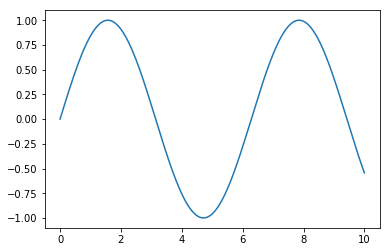

In [14]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [15]:
num_time_steps = 30

In [16]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, return_batch_ts=True)

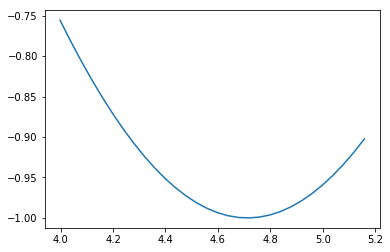

In [17]:
plt.plot(ts.flatten()[1:], y2.flatten())

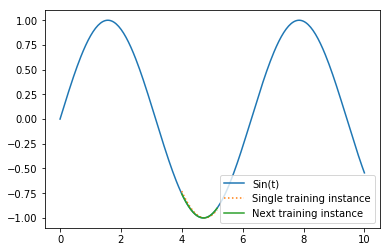

In [18]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y1.flatten(), ':', label='Single training instance')
plt.plot(ts.flatten()[1:], y2.flatten(), '-', label='Next training instance')

plt.legend()

In [19]:
# training data

In [20]:
train_inst = np.linspace(5, 5 + ts_data.resolution * num_time_steps + 1, num_time_steps + 1)
train_inst

array([5.        , 5.07333333, 5.14666667, 5.22      , 5.29333333,
       5.36666667, 5.44      , 5.51333333, 5.58666667, 5.66      ,
       5.73333333, 5.80666667, 5.88      , 5.95333333, 6.02666667,
       6.1       , 6.17333333, 6.24666667, 6.32      , 6.39333333,
       6.46666667, 6.54      , 6.61333333, 6.68666667, 6.76      ,
       6.83333333, 6.90666667, 6.98      , 7.05333333, 7.12666667,
       7.2       ])

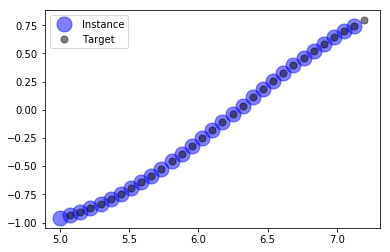

In [21]:
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),'bo', markersize=15, alpha=0.5, label='Instance')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, alpha=0.5, label='Target')

plt.legend()

## Create the model

In [22]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 10000
num_time_steps = 30
batch_size = 1

In [23]:
# placeholders

x = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_outputs])

In [24]:
# rnn cell layer

In [25]:
# BasicRNNCell, BasicLSTMCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs
)

In [26]:
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

In [27]:
loss = tf.reduce_mean(
    tf.square(outputs - y)
)

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [29]:
train = optimizer.minimize(loss)

In [30]:
init = tf.global_variables_initializer()

In [31]:
# session

In [32]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [33]:
saver = tf.train.Saver()

In [34]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, feed_dict={x: x_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})

            print(iteration, "\tMSE", mse)
    
    saver.save(sess, "./models/runn_time_series_model")

0 	MSE 0.29067114
100 	MSE 0.06826522
200 	MSE 0.10084869
300 	MSE 0.018884385
400 	MSE 0.009068141
500 	MSE 0.042689126
600 	MSE 0.00071488944
700 	MSE 0.0054085
800 	MSE 0.01262238
900 	MSE 0.002091909
1000 	MSE 0.004447886
1100 	MSE 0.003965581
1200 	MSE 0.008963775
1300 	MSE 0.008241182
1400 	MSE 0.0061584637
1500 	MSE 0.00242196
1600 	MSE 0.004983763
1700 	MSE 0.013885802
1800 	MSE 0.0046233186
1900 	MSE 0.0012934783
2000 	MSE 0.0029696925
2100 	MSE 0.0107032675
2200 	MSE 0.0014369343
2300 	MSE 0.00071180065
2400 	MSE 0.0009028897
2500 	MSE 0.00093355094
2600 	MSE 0.00015734341
2700 	MSE 0.0027889677
2800 	MSE 0.00021611218
2900 	MSE 0.00015617232
3000 	MSE 8.369736e-05
3100 	MSE 0.0002657104
3200 	MSE 0.00031592147
3300 	MSE 0.00033930427
3400 	MSE 0.00014026323
3500 	MSE 4.742226e-05
3600 	MSE 0.00040543813
3700 	MSE 0.0032555494
3800 	MSE 0.00075680466
3900 	MSE 0.003521066
4000 	MSE 9.994309e-05
4100 	MSE 0.0028974412
4200 	MSE 0.00073592755
4300 	MSE 0.00012612411
4400 	MSE 0

In [35]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver.restore(sess, "./models/runn_time_series_model")
    
    x_new = np.sin(
        np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs))
    )
    y_pred = sess.run(outputs, feed_dict={x: x_new})

INFO:tensorflow:Restoring parameters from ./models/runn_time_series_model


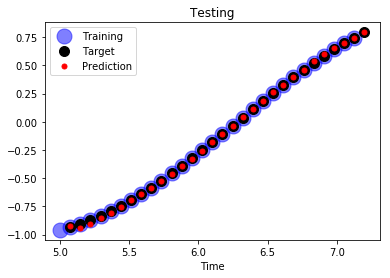

In [36]:
plt.title("Testing")

plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="Training")
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="Target")
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="Prediction")

plt.xlabel("Time")
plt.legend()

## Generating new sequence

In [37]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver.restore(sess, "./models/runn_time_series_model")
    
    zeros_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        x_batch = np.array(zeros_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={x: x_batch})
        
        zeros_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./models/runn_time_series_model


Text(0,0.5,'y')

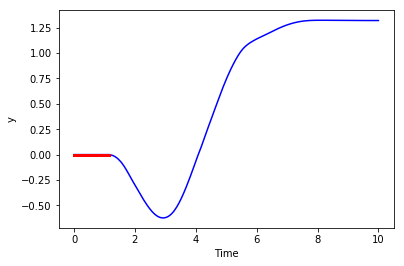

In [38]:
plt.plot(ts_data.x_data, zeros_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zeros_seq_seed[:num_time_steps], 'r', linewidth=3)

plt.xlabel('Time')
plt.ylabel('y')

In [39]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver.restore(sess, "./models/runn_time_series_model")
    
    training_instance = list(ts_data.y_true[:num_time_steps])
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={x: x_batch})
        
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./models/runn_time_series_model


Text(0,0.5,'y')

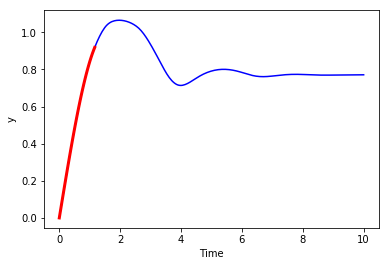

In [40]:
plt.plot(ts_data.x_data, training_instance, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth=3)

plt.xlabel('Time')
plt.ylabel('y')